In [11]:
# Creare un dataset con 1000 sample con 5 features + 1 target

import numpy as np

np.random.seed(0)

X = np.random.uniform(0, 10, size=(1000, 5))

w = np.array([2, -1, 0.5, 3, -2])

noise = np.random.normal(0, 1, size=(1000, 1))

y = X @ w + noise

In [12]:
X_mean = X.mean(axis=0)
X_mean

array([4.92493107, 4.92312792, 4.87032631, 5.04841245, 5.0817469 ])

In [13]:
X_std = X.std(axis=0)
X_std

array([2.83519685, 2.85863239, 2.85397829, 2.98154747, 2.91808666])

In [14]:
X_normalized = (X - X_mean) / X_std
X_normalized

array([[ 0.19864722,  0.77966154,  0.40550675,  0.13429918, -0.28964147],
       [ 0.54105945, -0.19143973,  1.41816205,  1.53887041, -0.42744848],
       [ 1.05541854,  0.12797073,  0.28385615,  1.41119804, -1.4980317 ],
       ...,
       [ 0.725006  , -0.02084625,  1.59017423, -1.46389085, -1.20756518],
       [-1.05080833, -0.9490982 , -0.881594  , -1.18056494,  0.63309587],
       [-0.96761309, -0.89853915, -1.01487937, -0.35603668,  1.54354022]])

In [19]:
X_train = X[:int(X.shape[0] * 0.8)] 
X_test  = X[int(X.shape[0] * 0.8):]

y_train = y[:int(X.shape[0] * 0.8)]
y_test  = y[:int(X.shape[0] * 0.8)]

In [ ]:
labels = [0, 2, 1, 0, 3, 2, 1]

categories = list(set(labels))

np.zeros((len(labels), len(categories)))



array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

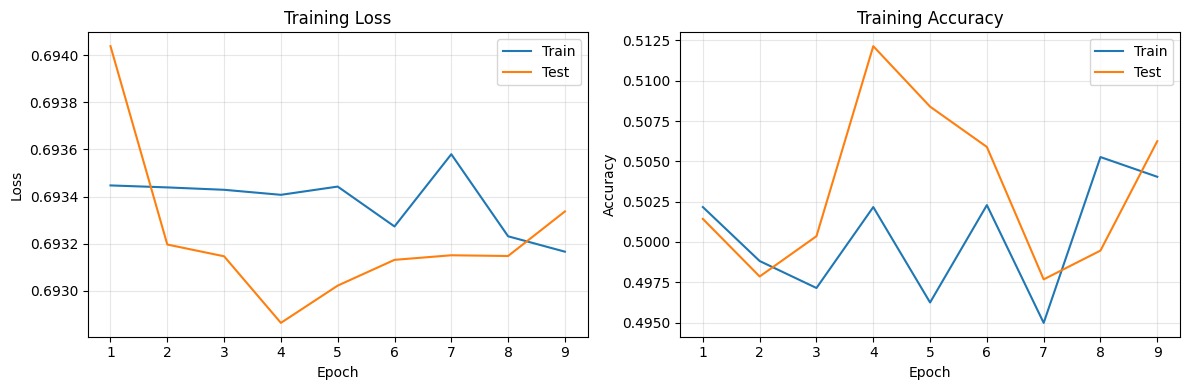

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Carica i dati
history = pd.read_csv('convnext_history.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(history['epoch'], history['train_loss'], label='Train')
ax1.plot(history['epoch'], history['test_loss'], label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['epoch'], history['train_acc'], label='Train')
ax2.plot(history['epoch'], history['test_acc'], label='Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# %%
# -------------------------
# LWLR con SGD (CORRETTO)
# -------------------------
def lwlr_SGD(x_q, X, y, t=0.5, lr=0.01, epochs=50):
    """
    Locally Weighted Linear Regression usando SGD
    
    Args:
        x_q: punto query (1, d)
        X: training data (m, d)  
        y: training labels (m, 1)
        t: bandwidth parameter
        lr: learning rate
        epochs: numero di epochs
    """
    m, d = X.shape
    theta = torch.zeros(d, 1, requires_grad=True)
    bias = torch.zeros(1, requires_grad=True)
    
    # Assicuriamoci che y sia della forma corretta
    if y.dim() == 1:
        y = y.unsqueeze(1)
    
    for epoch in range(epochs):
        total_loss = 0
        for i in range(m):
            xi = X[i:i+1]  # Mantieni dimensione (1, d)
            yi = y[i:i+1]  # Mantieni dimensione (1, 1)
            
            # Calcolo del peso
            diff = xi - x_q  # (1, d)
            wi = torch.exp(- diff.norm()**2 / (2 * t ** 2))
            
            # Predizione
            y_pred = xi @ theta + bias  # (1, 1)
            
            # Loss pesata
            loss = 0.5 * wi * (yi - y_pred) ** 2
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            with torch.no_grad():
                if theta.grad is not None:
                    theta -= lr * theta.grad
                if bias.grad is not None:
                    bias -= lr * bias.grad
            
            # Zero gradients
            if theta.grad is not None:
                theta.grad.zero_()
            if bias.grad is not None:
                bias.grad.zero_()
    
    # Predizione finale
    with torch.no_grad():
        y_pred = (x_q @ theta + bias).item()
    
    return y_pred, theta.detach(), bias.item()

def lwlr_BGD(x_q, X, y, t=0.5, lr=0.01, epochs=100):
    """
    Locally Weighted Linear Regression con Batch Gradient Descent
    
    Args:
        x_q: punto query (1, d)
        X: training data (m, d)
        y: training labels (m,) o (m, 1)
        t: bandwidth parameter
        lr: learning rate
        epochs: numero di epoche
    """
    m, d = X.shape
    theta = torch.zeros(d, 1, requires_grad=True)
    bias = torch.zeros(1, requires_grad=True)
    
    # Assicuriamoci che y sia colonna
    if y.dim() == 1:
        y = y.unsqueeze(1)  # (m,1)
    
    for epoch in range(epochs):
        # Differenze rispetto al punto query
        diff = X - x_q  # (m,d)
        wi = torch.exp(- diff.norm(dim=1)**2 / (2 * t**2))  # (m,)
        
        # Predizioni su tutti i dati
        y_pred = X @ theta + bias  # (m,1)
        
        # Loss pesata globale
        residuals = y - y_pred  # (m,1)
        loss = (wi.unsqueeze(1) * residuals**2).mean() / 2
        
        # Backward
        loss.backward()
        
        # Aggiornamento parametri
        with torch.no_grad():
            if theta.grad is not None:
                theta -= lr * theta.grad
            if bias.grad is not None:
                bias -= lr * bias.grad
        
        # Azzera gradienti
        if theta.grad is not None:
            theta.grad.zero_()
        if bias.grad is not None:
            bias.grad.zero_()
    
    # Predizione finale sul punto query
    with torch.no_grad():
        y_pred_q = (x_q @ theta + bias).item()
    
    return y_pred_q, theta.detach(), bias.item()

# %%
# -------------------------
# LWLR in forma chiusa (CORRETTO)
# -------------------------
def lwlr_CF(x_q, X, y, t=0.5):
    """
    Locally Weighted Linear Regression in forma chiusa
    
    Args:
        x_q: punto query (1, d)
        X: training data (m, d)
        y: training labels (m,) o (m, 1)
        t: bandwidth parameter
    """
    m, d = X.shape
    
    # Assicuriamoci che y sia un vettore colonna
    if y.dim() == 1:
        y = y.unsqueeze(1)  # (m, 1)
    
    # Aggiungi colonna di 1 per il bias
    X_aug = torch.cat([X, torch.ones(m, 1)], dim=1)  # (m, d+1)
    x_q_aug = torch.cat([x_q, torch.ones(1, 1)], dim=1)  # (1, d+1)
    
    # Calcolo dei pesi
    diff = X - x_q  # (m, d)
    weights = torch.exp(- diff.norm(dim=1)**2/ (2 * t ** 2))  # (m,)
    W = torch.diag(weights)  # (m, m)
    
    # Soluzione in forma chiusa
    XTW = X_aug.T @ W  # (d+1, m)
    XTWX = XTW @ X_aug  # (d+1, d+1)
    
    # Usa l'inversa diretta
    theta = torch.inverse(XTWX) @ XTW @ y  # (d+1, 1)
    
    # Predizione
    y_pred = (x_q_aug @ theta).item()
    
    return y_pred, theta[:-1], theta[-1].item()

In [62]:
# %%
# -------------------------
# Genera dati
# -------------------------
torch.manual_seed(42)  # Per riproducibilità
data_points = 50
X = torch.linspace(-5, 5, data_points).unsqueeze(1)  # (50, 1)
y_true = 3.5 * X.squeeze() + 1.5  # (50,)

# Rumore sinusoidale
amplitude = 4.0
frequency = 2.0
y = y_true + amplitude * torch.sin(frequency * X.squeeze())  # (50,)

print(f"Forma X: {X.shape}")
print(f"Forma y: {y.shape}")

# %%
# -------------------------
# Linear regression "globale" per confronto
# -------------------------
class LinearModelGD(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 1) * 0.1)
        self.bias = nn.Parameter(torch.randn(1) * 0.1)

    def forward(self, x):
        return x @ self.weights + self.bias
    
class LinearModelCF():
    def __init__(self, X, y):

        if y.dim() == 1:
            y = y.unsqueeze(1)

        m, d = X.shape

        X_aug = torch.cat([X, torch.ones(m, 1)], dim=1)

        theta = torch.inverse(X_aug.T @ X_aug) @ X_aug.T @ y

        self.weights = theta[:-1]
        self.bias = theta[-1].unsqueeze(0)

    def predict(self, x):
        return x @ self.weights + self.bias
    
model_cf = LinearModelCF(X, y)

model_sgd = LinearModelGD()
optimizer = optim.SGD(model_sgd.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training
for epoch in range(200):
    y_pred = model_sgd(X).squeeze()
    loss_value = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

print(f"Parametri linear regression CF:")
print(f"Peso: {model_cf.weights.item():.4f}, Bias: {model_cf.bias.item():.4f}")

print(f"Parametri linear regression SGD:")
print(f"Peso: {model_sgd.weights.item():.4f}, Bias: {model_sgd.bias.item():.4f}")

Forma X: torch.Size([50, 1])
Forma y: torch.Size([50])
Parametri linear regression CF:
Peso: 3.6494, Bias: 1.5000
Parametri linear regression SGD:
Peso: 3.6494, Bias: 1.4738


In [64]:
model_cf.weights

tensor([[3.6494]])

LWLR SGD (t=0.5):   0%|          | 0/25 [00:00<?, ?it/s]

LWLR CF (t=0.5): 100%|██████████| 25/25 [00:00<00:00, 2672.83it/s]


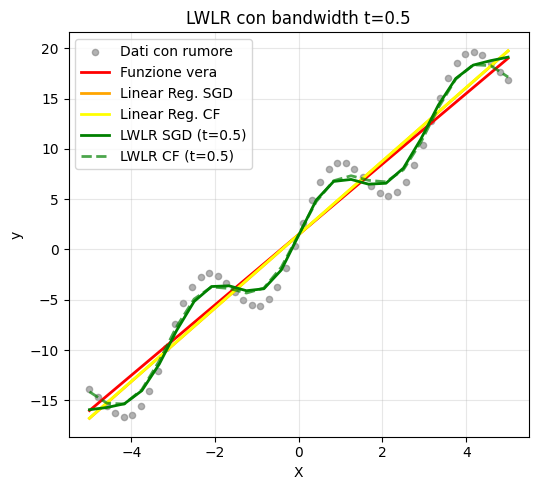

In [66]:
# -------------------------
# Test LWLR sui punti query
# -------------------------
X_query = torch.linspace(-5, 5, 25).unsqueeze(1)  # Riduciamo per velocità

# Test con diversi valori di bandwidth
bandwidths = [0.5]
colors = ['green', 'blue', 'purple']

plt.figure(figsize=(15, 5))

for idx, t_val in enumerate(bandwidths):
    plt.subplot(1, 3, idx + 1)
    
    # Predizioni con SGD
    y_preds_sgd = []
    for x_q in tqdm(X_query, desc=f"LWLR SGD (t={t_val})"):
        y_pred, _, _ = lwlr_BGD(x_q.unsqueeze(0), X, y, t=t_val, lr=0.5, epochs=50)
        y_preds_sgd.append(y_pred)
    y_preds_sgd = torch.tensor(y_preds_sgd)

    # Predizioni con forma chiusa
    y_preds_cf = []
    for x_q in tqdm(X_query, desc=f"LWLR CF (t={t_val})"):
        y_pred, _, _ = lwlr_CF(x_q.unsqueeze(0), X, y, t=t_val)
        y_preds_cf.append(y_pred)
    y_preds_cf = torch.tensor(y_preds_cf)

    # Predizioni modello CF globale
    y_pred_linear_cf = model_cf.predict(X_query)

    # Plot
    plt.scatter(X.squeeze(), y, alpha=0.6, s=20, color='gray', label="Dati con rumore")
    plt.plot(X.squeeze(), y_true, 'r-', label="Funzione vera", linewidth=2)
    plt.plot(X.squeeze(), model_sgd(X).squeeze().detach(), 'orange', 
             label="Linear Reg. SGD", linewidth=2)
    plt.plot(X_query.squeeze(), y_pred_linear_cf, 'yellow', 
             label="Linear Reg. CF", linewidth=2)
    plt.plot(X_query.squeeze(), y_preds_sgd, color=colors[idx], 
             label=f"LWLR SGD (t={t_val})", linewidth=2)
    plt.plot(X_query.squeeze(), y_preds_cf, color=colors[idx], 
             linestyle='--', label=f"LWLR CF (t={t_val})", linewidth=2, alpha=0.7)
    
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title(f"LWLR con bandwidth t={t_val}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CONFRONTO MSE SUL TEST SET


Predizioni LWLR SGD:   0%|          | 0/25 [00:00<?, ?it/s]

Predizioni LWLR CF: 100%|██████████| 25/25 [00:00<00:00, 2830.55it/s]


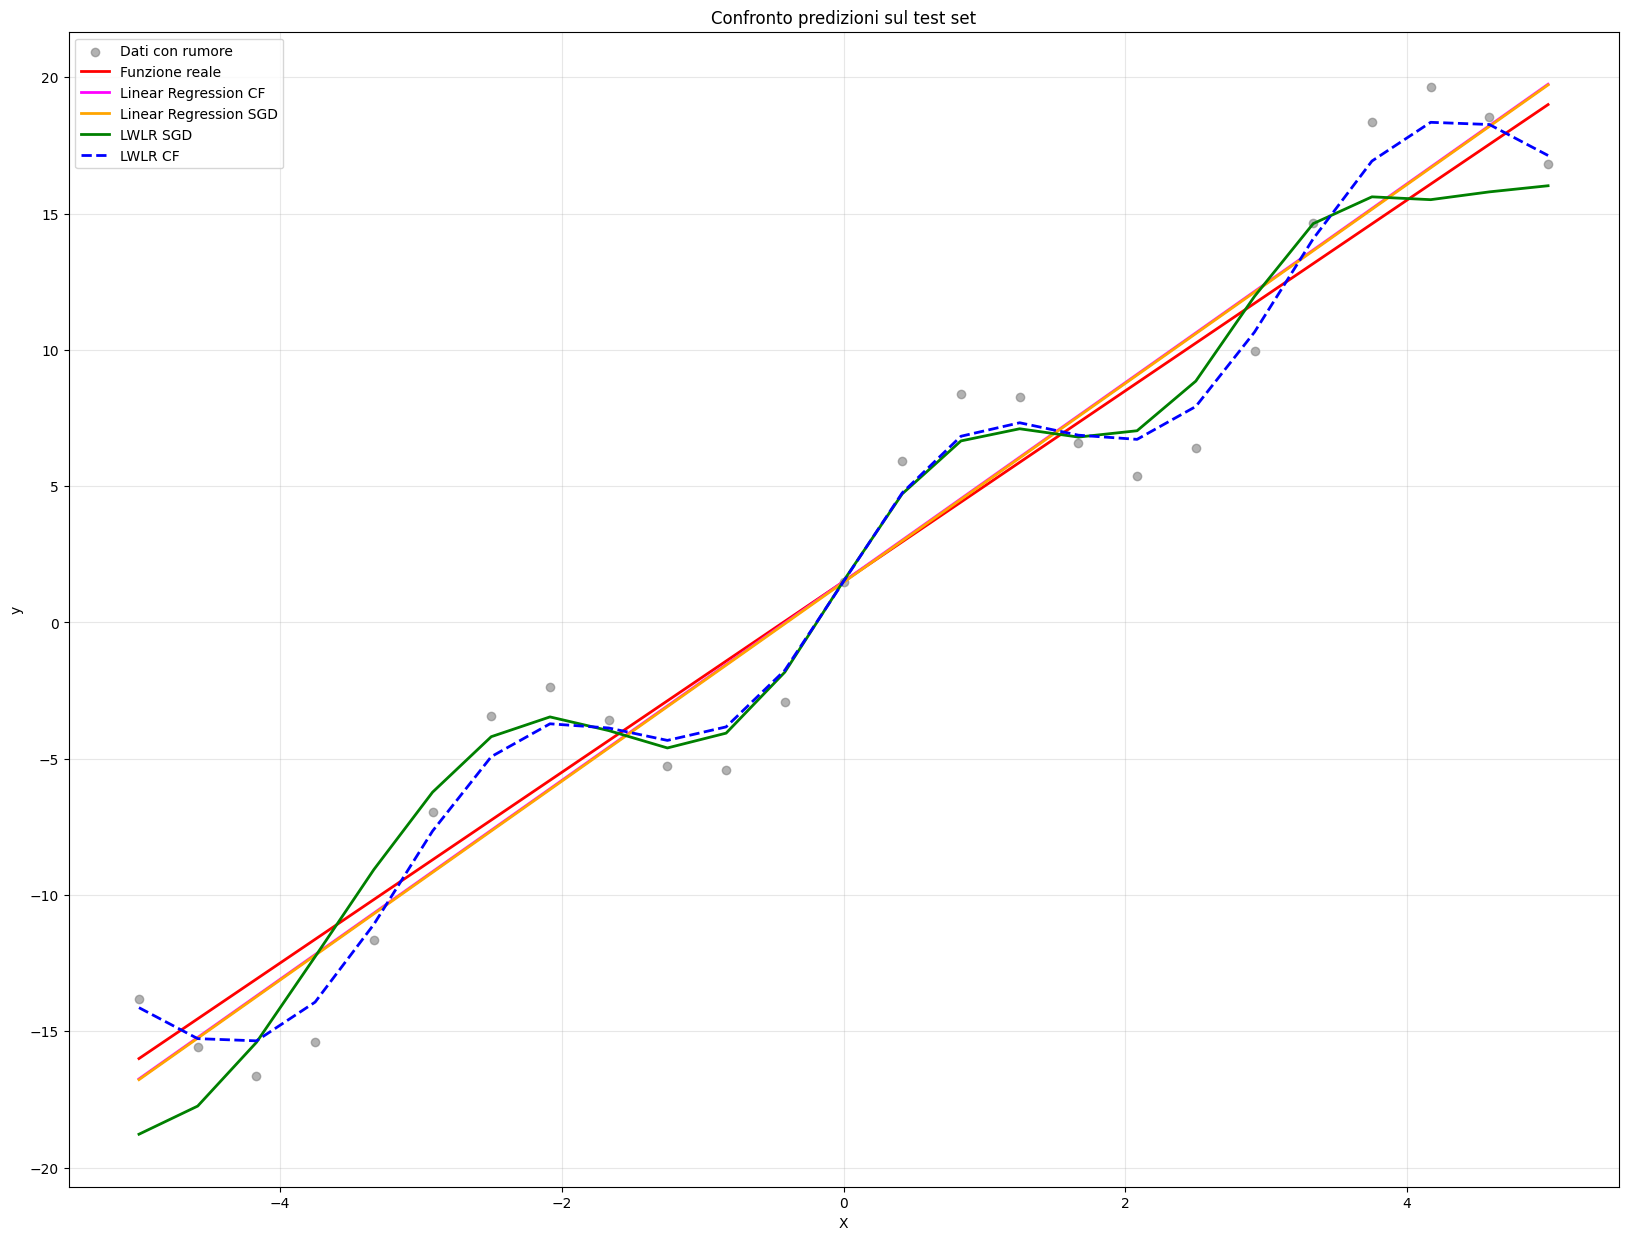

In [ ]:
from tqdm import tqdm

# -------------------------
# Confronto MSE su test set
# -------------------------
X_test = torch.linspace(-5, 5, 25).unsqueeze(1)
y_true_test = 3.5 * X_test.squeeze() + 1.5
y_test = y_true_test + amplitude * torch.sin(frequency * X_test.squeeze())

print("\n" + "="*60)
print("CONFRONTO MSE SUL TEST SET")
print("="*60)

plt.figure(figsize=(20,15))

# Dati rumorosi
plt.scatter(X_test.squeeze(), y_test, color='gray', alpha=0.6, label="Dati con rumore")

# Funzione reale
plt.plot(X_test.squeeze(), y_true_test, 'r-', linewidth=2, label="Funzione reale")

# Linear Regression CF
y_pred_cf = model_cf.predict(X_test)
plt.plot(X_test.squeeze(), y_pred_cf, 'magenta', linewidth=2, label="Linear Regression CF")

# Linear Regression SGD
y_pred_sgd = model_sgd(X_test).squeeze().detach()
plt.plot(X_test.squeeze(), y_pred_sgd, 'orange', linewidth=2, label="Linear Regression SGD")

# LWLR SGD
y_preds_lwlr_sgd = []
for x_q in tqdm(X_test, desc="Predizioni LWLR SGD"):
    y_pred, _, _ = lwlr_SGD(x_q.unsqueeze(0), X, y, t=0.5, lr=0.1, epochs=25)
    y_preds_lwlr_sgd.append(y_pred)
y_preds_lwlr_sgd = torch.tensor(y_preds_lwlr_sgd)
plt.plot(X_test.squeeze(), y_preds_lwlr_sgd, 'green', linewidth=2, label="LWLR SGD")

# LWLR CF
y_preds_lwlr_cf = []
for x_q in tqdm(X_test, desc="Predizioni LWLR CF"):
    y_pred, _, _ = lwlr_CF(x_q.unsqueeze(0), X, y, t=0.5)
    y_preds_lwlr_cf.append(y_pred)
y_preds_lwlr_cf = torch.tensor(y_preds_lwlr_cf)
plt.plot(X_test.squeeze(), y_preds_lwlr_cf, 'blue', linestyle='--', linewidth=2, label="LWLR CF")

plt.xlabel("X")
plt.ylabel("y")
plt.title("Confronto predizioni sul test set")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [49]:
# -------------------------
# Test di debugging: verifica su un singolo punto
# -------------------------
print("="*60)
print("TEST DI DEBUGGING SU SINGOLO PUNTO")
print("="*60)

x_test = torch.tensor([[0.0]])  # Punto al centro
print(f"Punto di test: {x_test.item()}")

# Calcola manualmente i pesi per alcuni punti
print("\nPesi per i primi 10 punti di training:")
for i in range(10):
    xi = X[i:i+1]
    diff = xi - x_test
    distance_sq = torch.sum(diff ** 2)
    weight = torch.exp(-distance_sq / (2 * 1.0 ** 2))
    print(f"x[{i}] = {xi.item():.2f}, distanza² = {distance_sq.item():.2f}, peso = {weight.item():.4f}")

# Confronta predizioni
y_pred_sgd, theta_sgd, bias_sgd = lwlr_SGD(x_test, X, y, t=1.0, lr=0.05, epochs=100)
y_pred_cf, theta_cf, bias_cf = lwlr_CF(x_test, X, y, t=1.0)

print(f"\nRisultati per x = 0:")
print(f"LWLR SGD: y = {y_pred_sgd:.4f}, theta = {theta_sgd.item():.4f}, bias = {bias_sgd:.4f}")
print(f"LWLR CF:  y = {y_pred_cf:.4f}, theta = {theta_cf.item():.4f}, bias = {bias_cf:.4f}")

# Valore atteso dalla funzione vera
expected_y = 3.5 * 0.0 + 1.5
print(f"Valore atteso (funzione vera): {expected_y:.4f}")

# Valore medio dei punti vicini (peso > 0.1)
nearby_mask = torch.exp(-torch.sum((X - x_test)**2, dim=1) / (2 * 1.0**2)) > 0.1
nearby_y = y[nearby_mask.squeeze()]
print(f"Media dei punti vicini: {nearby_y.mean().item():.4f} (n={len(nearby_y)})")

TEST DI DEBUGGING SU SINGOLO PUNTO
Punto di test: 0.0

Pesi per i primi 10 punti di training:
x[0] = -5.00, distanza² = 25.00, peso = 0.0000
x[1] = -4.80, distanza² = 23.00, peso = 0.0000
x[2] = -4.59, distanza² = 21.08, peso = 0.0000
x[3] = -4.39, distanza² = 19.25, peso = 0.0001
x[4] = -4.18, distanza² = 17.50, peso = 0.0002
x[5] = -3.98, distanza² = 15.84, peso = 0.0004
x[6] = -3.78, distanza² = 14.25, peso = 0.0008
x[7] = -3.57, distanza² = 12.76, peso = 0.0017
x[8] = -3.37, distanza² = 11.34, peso = 0.0034
x[9] = -3.16, distanza² = 10.01, peso = 0.0067

Risultati per x = 0:
LWLR SGD: y = 1.4252, theta = 4.5448, bias = 1.4252
LWLR CF:  y = 1.5000, theta = 4.5827, bias = 1.5000
Valore atteso (funzione vera): 1.5000
Media dei punti vicini: 1.5000 (n=22)
